In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt

### Load the data into train and test sets.

In [73]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Let's examine the data.

In [74]:
print(len(x_train))
print(len(x_test))
print(x_train[0])
print(y_train[0])

60000
10000
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 25

### The data consists of 60000 samples in the train dataset and 10000 samples in the test dataset. Each entry is represented by 28 lists each consisting of 28 numbers. This effectively creates a 28x28 grid of values each representing the pixel colour value in the sample 0 being black and 255 being white.

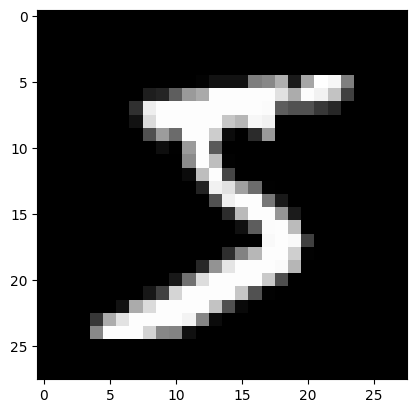

In [75]:
plt.imshow(x_train[0], cmap="gray")
plt.show()

### In order to ensure good model performance we will normalize colour values to fall between 0 and 1. To do this we can divide all values by 255. Moreover, we need to transform the samples from 28x28 to 28x28x1 to comply with Conv2D requirements. As it requires 3 dimensions for each sample (height, width, channels) we will add another axis which will act as the grayscale. While this step may seem redundant on the surface, as the image is already in grayscale and creating this additional dimension does not provide any new information, it is done to comply with Conv2D design.

In [76]:
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train[0])

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

### Let us check the shape of the train dataset to make sure it all complies with the Conv2D requirements.

In [86]:
print(x_train.shape)

(60000, 28, 28, 1)


### We can observe the shape of the x_train dataset consists of 4 dimensions: sample_size, height, width, channels.

### Let us now create full train and test datasets from x_train, y_train, x_test, y_test. For the train dataset we will shuffle it with a buffer of 10000 samples in order to prevent the model from learning any patterns related to the order in which data is being fed. Both datasets will be batched into batch sizes of 32 samples, meaning the weights will be adjusted every 32 samples instead of every sample in order to improve efficiency.

In [77]:
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

In [79]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras import Model

In [80]:
class MNISTModel(Model):
    def __init__(self):
        super(MNISTModel,self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation="relu")
        self.dense2 = Dense(10, activation="softmax")

    def call(self,x):
        x1 = self.conv1(x)
        x2 = self.maxpool1(x1)
        x3 = self.flatten(x2)
        x4 = self.dense1(x3)
        return self.dense2(x4)

model = MNISTModel()

In [81]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [82]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [83]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as gt:
        predictions = model(inputs)
        loss = loss_function(labels, predictions)

        gradients = gt.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

In [84]:
@tf.function
def test_step(inputs, labels):
    predictions = model(inputs)
    loss = loss_function(labels, predictions)
    
    test_loss(loss)
    test_accuracy(labels, predictions)

In [85]:
epochs = 5

for epoch in range(epochs):
    
    for train_inputs, train_labels in train_data:
        train_step(train_inputs, train_labels)
    
    for test_inputs, test_labels in test_data:
        test_step(test_inputs, test_labels)
    
    template = "Epochs: {}, Train loss: {}, Train accuracy: {}, Test loss: {}, Test accuracy: {}"
    print(template.format(
        epoch + 1,
        train_loss.result(),
        train_accuracy.result(),
        test_loss.result(),
        test_accuracy.result(),
      ))
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epochs: 1, Train loss: 0.15065811574459076, Train accuracy: 0.9554166793823242, Test loss: 0.06539621204137802, Test accuracy: 0.9789999723434448
Epochs: 2, Train loss: 0.05036211758852005, Train accuracy: 0.9844499826431274, Test loss: 0.03899462893605232, Test accuracy: 0.9872000217437744
Epochs: 3, Train loss: 0.03178831562399864, Train accuracy: 0.9897833466529846, Test loss: 0.04931146278977394, Test accuracy: 0.9836999773979187
Epochs: 4, Train loss: 0.01942736841738224, Train accuracy: 0.9938833117485046, Test loss: 0.044609952718019485, Test accuracy: 0.9865999817848206
Epochs: 5, Train loss: 0.014270610176026821, Train accuracy: 0.9954166412353516, Test loss: 0.05364861711859703, Test accuracy: 0.9840999841690063
